<a href="https://www.kaggle.com/code/utkarshx27/rainfall-prediction?scriptVersionId=225874641" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import seaborn as sns
import xgboost as xgb
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, auc, confusion_matrix, f1_score, mean_squared_error,
                             precision_score, recall_score, roc_auc_score, roc_curve)
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, StandardScaler
from statistics import mean, stdev

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.simplefilter("ignore", RuntimeWarning)

# Binary Prediction with a Rainfall Dataset

In [2]:
train = pd.read_csv("/kaggle/input/playground-series-s5e3/train.csv")
test = pd.read_csv("/kaggle/input/playground-series-s5e3/test.csv")
sub = pd.read_csv("/kaggle/input/playground-series-s5e3/sample_submission.csv")
original = pd.read_csv("/kaggle/input/rainfall-prediction-using-machine-learning/Rainfall.csv")
original.columns = original.columns.str.strip()
test.drop(columns = "id", inplace = True)
train.drop(columns = "id", inplace= True)

In [3]:
num_columns = ['day', 'pressure', 'maxtemp', 'temparature', 'mintemp',
       'dewpoint', 'humidity', 'cloud', 'sunshine', 'winddirection',
       'windspeed']

def summary(merged_data):
    print(f'data shape: {merged_data.shape}')

    summ = pd.DataFrame(columns=['dtype', 'missing', 'missing[%]', 'unique', 'min', 'max', 'median', 'std', 'outliers', 'lower_bound', 'upper_bound'])

    for col in num_columns:
        summ.loc[col, 'dtype'] = merged_data[col].dtype
        summ.loc[col, 'missing'] = merged_data[col].isnull().sum()
        summ.loc[col, 'missing[%]'] = merged_data[col].isnull().sum() / len(merged_data) * 100
        summ.loc[col, 'unique'] = merged_data[col].nunique()
        summ.loc[col, 'min'] = merged_data[col].min()
        summ.loc[col, 'max'] = merged_data[col].max()
        summ.loc[col, 'median'] = merged_data[col].median()
        summ.loc[col, 'std'] = merged_data[col].std()

        q1 = merged_data[col].quantile(0.25)
        q3 = merged_data[col].quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        outliers = merged_data[(merged_data[col] < lower_bound) | (merged_data[col] > upper_bound)][col]
        summ.loc[col, 'outliers'] = outliers.count()
        summ.loc[col, 'lower_bound'] = lower_bound
        summ.loc[col, 'upper_bound'] = upper_bound

    return summ

## Train Data Summary

In [4]:
summary(train)

data shape: (2190, 12)


,dtype,missing,missing[%],unique,min,max,median,std,outliers,lower_bound,upper_bound
day,int64,0,0.0,365,1,365,178.5,105.203592,0,-182.5,541.5
pressure,float64,0,0.0,236,999.0,1034.6,1013.0,5.655366,4,994.8375,1031.5375
maxtemp,float64,0,0.0,219,10.4,36.0,27.8,5.65433,0,6.45,46.05
temparature,float64,0,0.0,198,7.4,31.5,25.5,5.22241,0,5.65,42.05
mintemp,float64,0,0.0,199,4.0,29.8,23.85,5.05912,1,4.65,39.45
dewpoint,float64,0,0.0,218,-0.3,26.7,22.15,5.288406,26,4.5,37.3
humidity,float64,0,0.0,49,39.0,98.0,82.0,7.800654,28,60.5,104.5
cloud,float64,0,0.0,78,2.0,100.0,83.0,18.026498,129,40.5,116.5
sunshine,float64,0,0.0,120,0.0,12.1,2.4,3.626327,0,-9.2,16.4
winddirection,float64,0,0.0,35,10.0,300.0,70.0,80.002416,0,-200.0,440.0


## Original Data Summary

In [5]:
summary(original)

data shape: (366, 12)


,dtype,missing,missing[%],unique,min,max,median,std,outliers,lower_bound,upper_bound
day,int64,0,0.0,31,1,31,16.0,8.823592,0,-14.5,45.5
pressure,float64,0,0.0,188,998.5,1034.6,1013.0,6.414776,2,994.1,1032.5
maxtemp,float64,0,0.0,174,7.1,36.3,27.75,5.978343,0,6.2,46.2
temparature,float64,0,0.0,158,4.9,32.4,25.45,5.632813,0,4.1625,43.2625
mintemp,float64,0,0.0,157,3.1,30.0,23.7,5.594153,0,2.95,40.75
dewpoint,float64,0,0.0,158,-0.4,26.7,21.95,5.997021,5,2.8125,38.3125
humidity,int64,0,0.0,49,36,98,80.5,10.06247,10,57.0,105.0
cloud,int64,0,0.0,79,0,100,80.0,21.798012,4,13.0,133.0
sunshine,float64,0,0.0,104,0.0,12.1,3.5,3.934398,0,-11.05,19.75
winddirection,float64,1,0.273224,31,10.0,350.0,70.0,81.723724,0,-185.0,415.0


## Test Data Summary

In [6]:
summary(test)

data shape: (730, 11)


,dtype,missing,missing[%],unique,min,max,median,std,outliers,lower_bound,upper_bound
day,int64,0,0.0,365,1,365,183.0,105.438271,0,-181.0,547.0
pressure,float64,0,0.0,185,1000.0,1032.2,1012.7,5.505871,1,995.4125,1030.9125
maxtemp,float64,0,0.0,182,7.4,35.8,27.8,5.672521,1,7.5,45.1
temparature,float64,0,0.0,175,5.9,31.8,25.65,5.278098,1,7.0,41.2
mintemp,float64,0,0.0,171,4.2,29.1,23.9,5.170744,1,4.9625,39.2625
dewpoint,float64,0,0.0,172,-0.0,26.7,22.3,5.391169,11,4.5,37.3
humidity,float64,0,0.0,42,39.0,98.0,82.0,7.818714,7,59.625,106.625
cloud,float64,0,0.0,69,0.0,100.0,83.0,17.934121,40,40.5,116.5
sunshine,float64,0,0.0,110,0.0,11.8,2.2,3.639272,0,-9.2,16.2
winddirection,float64,1,0.136986,29,10.0,300.0,70.0,81.695458,0,-200.0,440.0


## Original + Train Data Summary

In [7]:
original['rainfall'] = original['rainfall'].map({"yes": 1, "no": 0})
imputer = SimpleImputer(strategy='mean')
original_imputed = pd.DataFrame(imputer.fit_transform(original), columns=original.columns)
merged_data = pd.concat([train, original_imputed], ignore_index=True)
test_imputed = pd.DataFrame(imputer.fit_transform(test), columns=test.columns)
summary(merged_data)

data shape: (2556, 12)


,dtype,missing,missing[%],unique,min,max,median,std,outliers,lower_bound,upper_bound
day,float64,0,0.0,365,1.0,365.0,148.0,113.147285,0,-272.5,571.5
pressure,float64,0,0.0,242,998.5,1034.6,1013.0,5.769101,6,994.8,1031.6
maxtemp,float64,0,0.0,222,7.1,36.3,27.8,5.700976,0,6.45,46.05
temparature,float64,0,0.0,202,4.9,32.4,25.5,5.282473,1,5.65,42.05
mintemp,float64,0,0.0,205,3.1,30.0,23.8,5.138897,2,4.25,39.85
dewpoint,float64,0,0.0,220,-0.4,26.7,22.1,5.396788,36,4.5,37.3
humidity,float64,0,0.0,52,36.0,98.0,81.0,8.18672,53,62.0,102.0
cloud,float64,0,0.0,81,0.0,100.0,83.0,18.678173,125,38.0,118.0
sunshine,float64,0,0.0,120,0.0,12.1,2.4,3.678826,0,-9.5,16.9
winddirection,float64,0,0.0,37,10.0,350.0,70.0,80.227294,0,-200.0,440.0


In [8]:
summary(test_imputed)

data shape: (730, 11)


,dtype,missing,missing[%],unique,min,max,median,std,outliers,lower_bound,upper_bound
day,float64,0,0.0,365,1.0,365.0,183.0,105.438271,0,-181.0,547.0
pressure,float64,0,0.0,185,1000.0,1032.2,1012.7,5.505871,1,995.4125,1030.9125
maxtemp,float64,0,0.0,182,7.4,35.8,27.8,5.672521,1,7.5,45.1
temparature,float64,0,0.0,175,5.9,31.8,25.65,5.278098,1,7.0,41.2
mintemp,float64,0,0.0,171,4.2,29.1,23.9,5.170744,1,4.9625,39.2625
dewpoint,float64,0,0.0,172,-0.0,26.7,22.3,5.391169,11,4.5,37.3
humidity,float64,0,0.0,42,39.0,98.0,82.0,7.818714,7,59.625,106.625
cloud,float64,0,0.0,69,0.0,100.0,83.0,17.934121,40,40.5,116.5
sunshine,float64,0,0.0,110,0.0,11.8,2.2,3.639272,0,-9.2,16.2
winddirection,float64,0,0.0,30,10.0,300.0,70.0,81.639407,0,-200.0,440.0


## Lr Model

[I 2025-03-05 10:06:50,910] A new study created in memory with name: no-name-a20049f7-70d0-4e1d-8f72-68d0fb565d8e
[I 2025-03-05 10:06:50,986] Trial 0 finished with value: 0.8919024056853594 and parameters: {'C': 0.02535437554377871, 'solver': 'lbfgs'}. Best is trial 0 with value: 0.8919024056853594.
[I 2025-03-05 10:06:51,063] Trial 1 finished with value: 0.8914335591193078 and parameters: {'C': 83.16122590893565, 'solver': 'lbfgs'}. Best is trial 0 with value: 0.8919024056853594.
[I 2025-03-05 10:06:51,138] Trial 2 finished with value: 0.891445632069183 and parameters: {'C': 6.739232551280998, 'solver': 'lbfgs'}. Best is trial 0 with value: 0.8919024056853594.
[I 2025-03-05 10:06:51,188] Trial 3 finished with value: 0.8914494986865209 and parameters: {'C': 30.178703756543232, 'solver': 'liblinear'}. Best is trial 0 with value: 0.8919024056853594.
[I 2025-03-05 10:06:51,235] Trial 4 finished with value: 0.8914536065508416 and parameters: {'C': 6.490421890654444, 'solver': 'liblinear'}.

ROC AUC Score: 0.8957682606322481
Accuracy: 0.8583724569640062
Precision: 0.8806339772164438
Recall: 0.9362822538177988
F1 Score: 0.9076059213884635


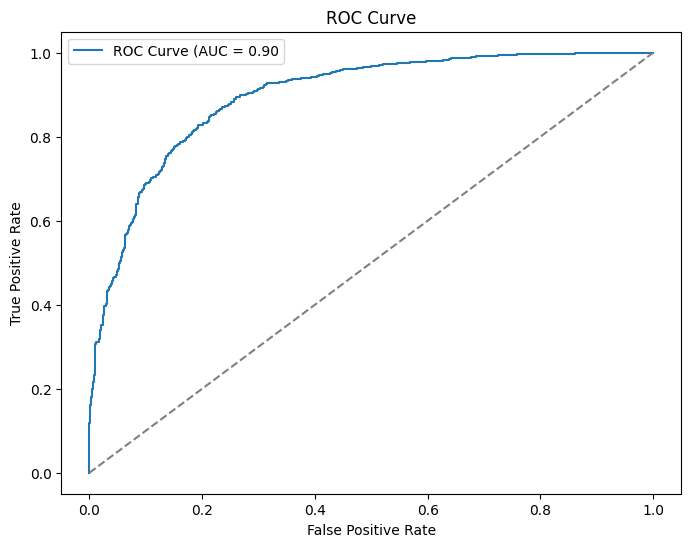

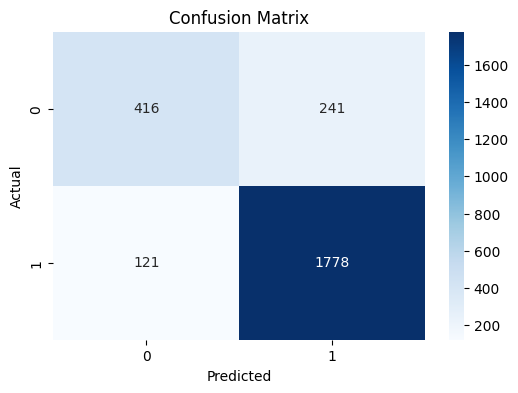

Submission file saved as submission2.csv


In [9]:
X = merged_data.drop(columns=['rainfall']) 
y = merged_data['rainfall'] 


scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

def objective(trial):
    C = trial.suggest_loguniform('C', 1e-4, 1e2)
    solver = trial.suggest_categorical("solver", ["liblinear", "lbfgs"])
    
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = []
    
    for train_idx, val_idx in skf.split(X_scaled, y):
        X_train, X_val = X_scaled[train_idx], X_scaled[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
        
        model = LogisticRegression(C=C, solver=solver, random_state=42)
        model.fit(X_train, y_train)
        y_pred = model.predict_proba(X_val)[:, 1]
        scores.append(roc_auc_score(y_val, y_pred))
    
    return np.mean(scores)


study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)


final_model = LogisticRegression(solver='newton-cg', penalty='none', max_iter=10000, random_state=43, C=1.0)
final_model.fit(X_scaled, y)


test_imputed_scaled = scaler.transform(test_imputed)
test_predictions = final_model.predict_proba(test_imputed_scaled)[:, 1]


y_train_pred = final_model.predict_proba(X_scaled)[:, 1]
y_train_pred_labels = final_model.predict(X_scaled)

roc_auc = roc_auc_score(y, y_train_pred)
accuracy = accuracy_score(y, y_train_pred_labels)
precision = precision_score(y, y_train_pred_labels)
recall = recall_score(y, y_train_pred_labels)
f1 = f1_score(y, y_train_pred_labels)

print(f"ROC AUC Score: {roc_auc}")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")


fpr, tpr, _ = roc_curve(y, y_train_pred)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='grey')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()


plt.figure(figsize=(6, 4))
conf_matrix = confusion_matrix(y, y_train_pred_labels)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


sub['rainfall'] = test_predictions
sub.to_csv("submission1.csv", index=False)
print("Submission file saved as submission2.csv")